In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from IPython.display import FileLink
import imgaug as ia
from imgaug import augmenters as iaa
from random import randint
from skimage.filters import gaussian_filter
import Augmentor

plt.ion()   # interactive mode

In [2]:
STORAGE_DIR = '/home/tyler/storage/dogbreed2/'
SAMPLE_SUBMISSION = STORAGE_DIR + 'sample_submission.csv'
RESULT_FILE = STORAGE_DIR + 'results/dogbreeds_results.csv'

In [ ]:
image_size = 224

p_train = Augmentor.Pipeline()
p_train.rotate(probability=0.4, max_left_rotation=25, max_right_rotation=25)
p_train.resize(probability=1, width=image_size, height=image_size, resample_filter="NEAREST")
p_train.random_distortion(probability=0.2, grid_width=5, grid_height=5, magnitude=5)
p_train.skew_corner(probability=0.3, magnitude=0.3)
p_train.skew(probability=0.3, magnitude=0.3)
p_train.flip_random(probability=0.2)


p_test = Augmentor.Pipeline()
p_test.resize(probability=1, width=image_size, height=image_size, resample_filter="NEAREST")

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(STORAGE_DIR, x),data_transforms[x])
        for x in ['train', 'valid', 'test']
}

dataloders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,shuffle=x != 'test', num_workers=4)
        for x in ['train', 'valid', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

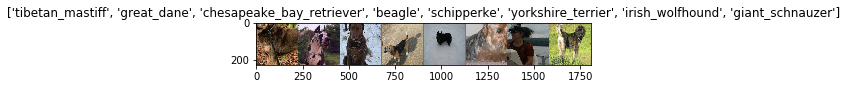

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_batch = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                running_batch +=1

            epoch_loss = running_loss / running_batch
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
model_conv = torchvision.models.densenet161(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 120)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.classifier.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.3276 Acc: 0.4500
valid Loss: 0.6583 Acc: 0.7970
Epoch 1/19
----------
train Loss: 1.2881 Acc: 0.6491
valid Loss: 0.5105 Acc: 0.8375
Epoch 2/19
----------
train Loss: 0.9567 Acc: 0.7447
valid Loss: 0.4250 Acc: 0.8630
Epoch 3/19
----------
train Loss: 0.9233 Acc: 0.7542
valid Loss: 0.4198 Acc: 0.8630
Epoch 4/19
----------
train Loss: 0.9304 Acc: 0.7547
valid Loss: 0.4073 Acc: 0.8650
Epoch 5/19
----------
train Loss: 0.8995 Acc: 0.7630
valid Loss: 0.4107 Acc: 0.8700
Epoch 6/19
----------
train Loss: 0.9100 Acc: 0.7592
valid Loss: 0.3998 Acc: 0.8710
Epoch 7/19
----------
train Loss: 0.8926 Acc: 0.7664
valid Loss: 0.4076 Acc: 0.8690
Epoch 8/19
----------
train Loss: 0.8982 Acc: 0.7660
valid Loss: 0.4074 Acc: 0.8665
Epoch 9/19
----------
train Loss: 0.8764 Acc: 0.7754
valid Loss: 0.4078 Acc: 0.8715
Epoch 10/19
----------
train Loss: 0.9188 Acc: 0.7592
valid Loss: 0.4057 Acc: 0.8680
Epoch 11/19
----------
train Loss: 0.8768 Acc: 0.7765
valid Loss: 0.4139 Ac

Process Process-133:
Process Process-135:
Process Process-136:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tyler/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Process Process-134:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/m

KeyboardInterrupt: 

In [9]:
path = STORAGE_DIR + 'results/'
torch.save(model_conv.state_dict(), path + 'weights.torch')

In [17]:
model_conv.load_state_dict(torch.load(path + 'weights.torch'))
for param in model_conv.parameters():
    param.requires_grad = True

In [19]:
unfrz_optim = torch.optim.SGD(model_conv.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(unfrz_optim, step_size=7, gamma=0.1)

In [20]:
model_conv = train_model(model_conv, criterion, unfrz_optim,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8780 Acc: 0.7676
valid Loss: 0.3967 Acc: 0.8740
Epoch 1/19
----------
train Loss: 0.8206 Acc: 0.7801
valid Loss: 0.3859 Acc: 0.8700
Epoch 2/19
----------
train Loss: 0.7919 Acc: 0.7931
valid Loss: 0.3971 Acc: 0.8710
Epoch 3/19
----------
train Loss: 0.7894 Acc: 0.7952
valid Loss: 0.4045 Acc: 0.8660
Epoch 4/19
----------
train Loss: 0.7491 Acc: 0.8000
valid Loss: 0.3897 Acc: 0.8730
Epoch 5/19
----------
train Loss: 0.7110 Acc: 0.8160
valid Loss: 0.4086 Acc: 0.8670
Epoch 6/19
----------


Process Process-234:
Process Process-236:
Process Process-233:
Process Process-235:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tyler/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/tyler/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tyler/anaconda

KeyboardInterrupt: 

In [ ]:
visualize_model(model_conv)

In [ ]:
torch.save(model_conv.state_dict(), path + 'weights2.torch')

In [ ]:
model_conv.load_state_dict(torch.load(path + 'weights2.torch'))
model_conv.eval()
predictions = []

for index, test_value in enumerate(dataloders['test']):
    val = test_value[0].cuda()
    
    input = torch.autograd.Variable(val, volatile=True)
    output = model_conv(input)
    predictions.append(func.softmax(output, dim=1).cpu().data.numpy())
    print('\r ' + str(index), end='') 
    
predictions = np.concatenate(predictions)
    
predictions

In [ ]:
imgs = dataloders['test'].dataset.imgs
filenames = []
for file_loc in imgs:
    filenames.append(os.path.splitext(os.path.basename(file_loc[0]))[0])

In [ ]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)
columns = sample_submission.columns.values
rows = []

for index, row in enumerate(predictions):
    row = row.tolist()
    row.insert(0, filenames[index])
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)

In [ ]:
df.to_csv(RESULT_FILE, sep=',', index=False)

In [ ]:
%cd ~/notebooks/dogbreed
FileLink("dogbreeds_results.csv")